<a href="https://colab.research.google.com/github/gimhaninavodya/SE4050-Lab-8-DeepLearning/blob/main/Reinforcement_Learning_Lab_2_Question_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports & Setup
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

class GridWorld:
    def __init__(self, size=5):
        self.size = size
        self.start_state = (0, 0)
        self.goal_state = (size-1, size-1)
        self.state = self.start_state
        self.walls = [(1, 1), (2, 2), (3, 1)]  # optional walls
        self.action_space = 4  # up, down, left, right
        self.observation_space = 2  # (x, y)

    def reset(self):
        self.state = self.start_state
        return np.array(self.state, dtype=np.float32)

    def step(self, action):
        x, y = self.state
        # up, down, left, right
        if action == 0:    # up
            x = max(x-1, 0)
        elif action == 1:  # down
            x = min(x+1, self.size-1)
        elif action == 2:  # left
            y = max(y-1, 0)
        elif action == 3:  # right
            y = min(y+1, self.size-1)

        next_state = (x, y)
        done = False
        reward = -1  # small penalty for each step

        if next_state in self.walls:
            reward = -5  # penalty for hitting a wall
        elif next_state == self.goal_state:
            reward = 10  # reward for reaching the goal
            done = True

        self.state = next_state
        return np.array(next_state, dtype=np.float32), reward, done, {}

# Fix numpy compatibility
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


# Define DQN Network

In [ ]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Epsilon-Greedy Action Selection

In [ ]:
def select_action(state, policy_net, epsilon, n_actions):
    if random.random() < epsilon:  # explore
        return random.randrange(n_actions)
    else:  # exploit
        state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = policy_net(state_t)
        return q_values.argmax().item()

# Training Function

In [ ]:
def train_dqn(epsilon_value, episodes=300):
    env = GridWorld(size=5)
    state_dim = env.observation_space
    n_actions = env.action_space

    policy_net = DQN(state_dim, n_actions).to(device)
    optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
    gamma = 0.99  # future reward discount

    episode_rewards = []

    for ep in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = select_action(state, policy_net, epsilon_value, n_actions)
            next_state, reward, done, _ = env.step(action)

            # convert to tensors
            state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
            next_state_t = torch.FloatTensor(next_state).unsqueeze(0).to(device)

            # compute target Q-value
            with torch.no_grad():
                target = reward + gamma * policy_net(next_state_t).max().item() * (1 - done)

            # current Q prediction
            q_values = policy_net(state_t)
            q_value = q_values[0, action]

            # loss & update
            loss = F.mse_loss(q_value, torch.tensor(target, device=device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state
            total_reward += reward

        episode_rewards.append(total_reward)

        if (ep + 1) % 50 == 0:
            print(f"ε={epsilon_value}, Episode {ep+1}, Avg Reward: {np.mean(episode_rewards[-50:]):.2f}")

    return episode_rewards

# Run for Different Epsilons

In [ ]:
epsilons = [0.1, 0.5, 0.9]
results = {}

for eps in epsilons:
    print(f"\nTraining with ε = {eps}")
    rewards = train_dqn(eps, episodes=300)
    results[eps] = rewards


Training with ε = 0.1
ε=0.1, Episode 50, Avg Reward: -285.12
ε=0.1, Episode 100, Avg Reward: 0.70
ε=0.1, Episode 150, Avg Reward: 1.82
ε=0.1, Episode 200, Avg Reward: 1.58
ε=0.1, Episode 250, Avg Reward: 1.34
ε=0.1, Episode 300, Avg Reward: 1.68

Training with ε = 0.5
ε=0.5, Episode 50, Avg Reward: -45.02
ε=0.5, Episode 100, Avg Reward: -8.86
ε=0.5, Episode 150, Avg Reward: -8.14
ε=0.5, Episode 200, Avg Reward: -10.30
ε=0.5, Episode 250, Avg Reward: -5.30
ε=0.5, Episode 300, Avg Reward: -6.44

Training with ε = 0.9
ε=0.9, Episode 50, Avg Reward: -77.20
ε=0.9, Episode 100, Avg Reward: -95.48
ε=0.9, Episode 150, Avg Reward: -76.46
ε=0.9, Episode 200, Avg Reward: -93.02
ε=0.9, Episode 250, Avg Reward: -90.14
ε=0.9, Episode 300, Avg Reward: -88.74


# Plot 3 Separate Graphs

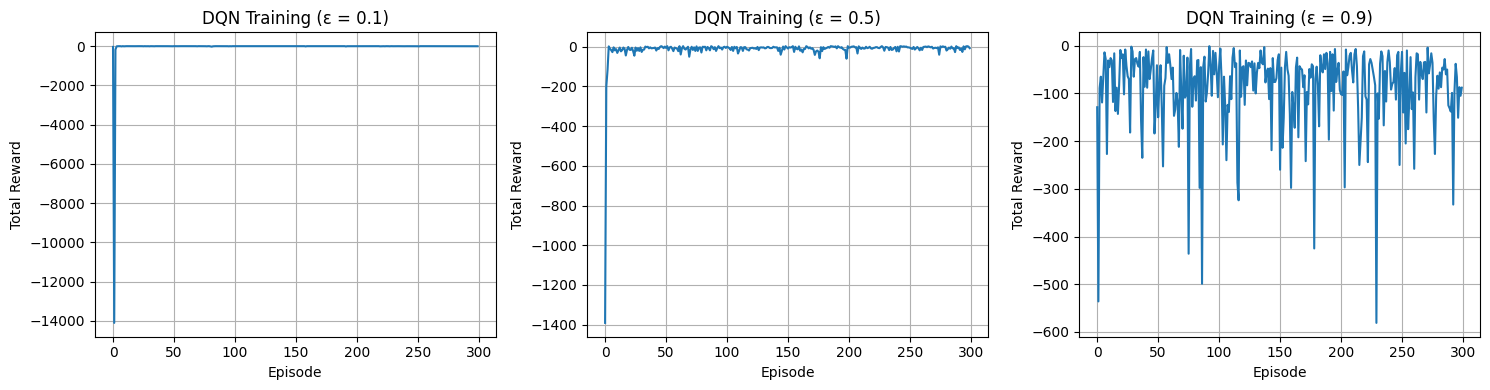

In [ ]:
plt.figure(figsize=(15, 4))
for i, (eps, rewards) in enumerate(results.items()):
    plt.subplot(1, 3, i + 1)
    plt.plot(rewards, color='tab:blue')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"DQN Training (ε = {eps})")
    plt.grid(True)
plt.tight_layout()
plt.show()